# Capital Asset Pricing Model (CAPM) Analysis

This notebook walks through a CAPM analysis, focusing on data management, beta analysis, CAPM implementation, and visualizations. CAPM is a foundational asset pricing model that helps determine expected returns based on an asset's systematic risk, as measured by its beta in relation to the overall market.

---

## Key Steps in CAPM Analysis

### 1. Data Management
   CAPM relies on historical price data for individual stocks and a market index (typically the S&P 500) to estimate returns and measure risk.
   
   **Steps:**
   - **Download Historical Price Data**: Collect data for individual stocks and a market benchmark (e.g., S&P 500) using financial data APIs like `yfinance`.
   - **Calculate Daily Returns**: Compute daily returns for each stock and the market index to capture day-to-day price movements.
   
   *Purpose*: Daily returns provide the necessary inputs for estimating the relationship between a stock’s returns and the market’s returns, which is central to calculating beta.

### 2. Beta Analysis
   Beta represents a stock's sensitivity to market movements, indicating its systematic risk. This section will calculate both individual and portfolio betas.
   
   **Steps:**
   - **Individual Stock Betas**: Perform a linear regression between each stock's daily returns and the market index returns. The slope of the regression line represents the stock's beta.
   - **Portfolio Beta**: Calculate the weighted average beta for a portfolio based on the betas of individual stocks and their respective weights in the portfolio.
   - **Statistical Significance**: Calculate R-squared and p-values for the beta estimates to assess the model's explanatory power and the statistical significance of beta.

   *Purpose*: Beta analysis allows us to quantify how much risk a stock or portfolio has relative to the market, which is critical in determining expected returns through CAPM.

### 3. CAPM Implementation
   Using the CAPM formula, calculate the expected return for each stock or portfolio:
   
   \[
   \text{Expected Return} = \text{Risk-Free Rate} + \beta \times (\text{Market Return} - \text{Risk-Free Rate})
   \]
   
   **Steps:**
   - **Determine the Risk-Free Rate**: Use a proxy like the yield on U.S. Treasury securities.
   - **Calculate Market Risk Premium**: Compute the difference between the expected market return and the risk-free rate.
   - **Apply CAPM Formula**: For each stock or portfolio, calculate the expected return based on the risk-free rate, beta, and market risk premium.

   *Purpose*: CAPM provides a theoretical expected return based on systematic risk, helping investors assess whether a stock’s return justifies its risk.

### 4. Visualizations
   Visualizations help interpret and communicate CAPM-related insights, comparing stock betas, the relationship between beta and explanatory power, and overall portfolio risk.

   **Steps:**
   - **Beta Comparison Bar Plot**: Visualize individual stock betas to see how each stock’s risk compares to the market.
   - **Beta vs. R-squared Scatter Plot**: Plot betas against R-squared values to evaluate how much of the stock's return variability is explained by market movements.
   - **Returns Scatter Plot with Beta Lines**: Show individual stock returns vs. market returns with regression lines for beta, helping to visualize each stock's market sensitivity.
   - **Comprehensive Portfolio Analysis**: Use charts to depict the expected vs. actual portfolio returns, portfolio beta, and its alignment with CAPM predictions.

   *Purpose*: These visualizations provide a deeper understanding of stock and portfolio risk, the fit of CAPM in explaining returns, and any deviations between expected and actual returns.

---

### Summary of CAPM Analysis

CAPM analysis integrates data, statistics, and visualizations to assess expected returns based on systematic risk. This model is essential for portfolio management and investment decision-making, offering insights into whether assets are priced appropriately given their risk profiles.


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Set up necessary functions

In [4]:
class PortfolioAnalyzer:
    def __init__(self, tickers, start_date, end_date, market_ticker='^GSPC'):
        """
        Initialize the Portfolio Analyzer
        
        Parameters:
        tickers (list): List of stock tickers
        start_date (str): Start date in 'YYYY-MM-DD' format
        end_date (str): End date in 'YYYY-MM-DD' format
        market_ticker (str): Market index ticker (default: S&P 500)
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.market_ticker = market_ticker
        self.stock_data = None
        self.market_data = None
        self.returns_data = None
        self.betas = None
        self.expected_returns = None
        
    def download_data(self):
        """
        Download stock and market data from Yahoo Finance
        """
        print("Downloading data...")
        
        # Download stock data
        self.stock_data = pd.DataFrame()
        for ticker in self.tickers:
            try:
                stock = yf.download(ticker, self.start_date, self.end_date)['Adj Close']
                self.stock_data[ticker] = stock
                print(f"Downloaded data for {ticker}")
            except Exception as e:
                print(f"Error downloading {ticker}: {e}")
        
        # Download market data
        try:
            self.market_data = yf.download(self.market_ticker, self.start_date, 
                                         self.end_date)['Adj Close']
            print(f"Downloaded market data ({self.market_ticker})")
        except Exception as e:
            print(f"Error downloading market data: {e}")
            
        # Calculate returns
        self.calculate_returns()
        
    def calculate_returns(self):
        """
        Calculate daily returns for stocks and market
        """
        # Calculate stock returns
        stock_returns = self.stock_data.pct_change()
        
        # Calculate market returns
        market_returns = self.market_data.pct_change()
        
        # Combine all returns
        self.returns_data = pd.concat([stock_returns, market_returns], axis=1)
        self.returns_data.columns = list(self.stock_data.columns) + ['Market']
        
        # Drop any missing values
        self.returns_data = self.returns_data.dropna()
        
    def calculate_individual_betas(self):
        """
        Calculate beta for each individual security
        Returns DataFrame with beta and R-squared values
        """
        self.betas = pd.DataFrame(index=self.tickers,
                                columns=['Beta', 'Alpha', 'R-squared', 'P-value'])
        
        market_return = self.returns_data['Market']
        
        for ticker in self.tickers:
            stock_return = self.returns_data[ticker]
            
            # Perform regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(market_return, 
                                                                          stock_return)
            
            self.betas.loc[ticker] = {
                'Beta': slope,
                'Alpha': intercept,
                'R-squared': r_value**2,
                'P-value': p_value
            }
            
        return self.betas
    
    def calculate_portfolio_beta(self, weights=None):
        """
        Calculate beta for the entire portfolio
        
        Parameters:
        weights (array-like): Portfolio weights. If None, equal weights are assumed.
        
        Returns:
        float: Portfolio beta
        """
        if weights is None:
            weights = np.ones(len(self.tickers)) / len(self.tickers)
            
        if self.betas is None:
            self.calculate_individual_betas()
            
        portfolio_beta = np.sum(weights * self.betas['Beta'])
        return portfolio_beta
    
    def calculate_capm_returns(self, risk_free_rate):
        """
        Calculate expected returns using CAPM
        
        Parameters:
        risk_free_rate (float): Risk-free rate (annual)
        
        Returns:
        DataFrame: Expected returns for each stock
        """
        if self.betas is None:
            self.calculate_individual_betas()
            
        # Calculate market return (annualized)
        market_return_annual = (1 + self.returns_data['Market'].mean())**252 - 1
        
        # Calculate expected returns
        self.expected_returns = pd.DataFrame(index=self.tickers,
                                           columns=['Expected Return'])
        
        for ticker in self.tickers:
            beta = self.betas.loc[ticker, 'Beta']
            expected_return = risk_free_rate + beta * (market_return_annual - risk_free_rate)
            self.expected_returns.loc[ticker, 'Expected Return'] = expected_return
            
        return self.expected_returns
    
    def plot_beta_analysis(self):
        """
        Create visualizations for beta analysis
        """
        if self.betas is None:
            self.calculate_individual_betas()
            
        # Create figure with multiple subplots
        fig = plt.figure(figsize=(20, 12))
        gs = plt.GridSpec(2, 2)
        
        # 1. Beta comparison bar plot
        ax1 = fig.add_subplot(gs[0, 0])
        self.betas['Beta'].sort_values().plot(kind='bar', ax=ax1)
        ax1.set_title('Stock Betas Comparison')
        ax1.set_ylabel('Beta')
        ax1.axhline(y=1, color='r', linestyle='--', alpha=0.3)
        plt.xticks(rotation=45)
        
        # 2. Beta vs R-squared scatter plot
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.scatter(self.betas['Beta'], self.betas['R-squared'])
        for i, ticker in enumerate(self.tickers):
            ax2.annotate(ticker, (self.betas.loc[ticker, 'Beta'], 
                                self.betas.loc[ticker, 'R-squared']))
        ax2.set_xlabel('Beta')
        ax2.set_ylabel('R-squared')
        ax2.set_title('Beta vs R-squared')
        
        # 3. Returns scatter plot with beta lines
        ax3 = fig.add_subplot(gs[1, :])
        market_returns = self.returns_data['Market']
        
        for ticker in self.tickers:
            stock_returns = self.returns_data[ticker]
            beta = self.betas.loc[ticker, 'Beta']
            alpha = self.betas.loc[ticker, 'Alpha']
            
            # Plot scatter points
            ax3.scatter(market_returns, stock_returns, alpha=0.5, label=ticker)
            
            # Plot regression line
            x_range = np.array([market_returns.min(), market_returns.max()])
            y_range = alpha + beta * x_range
            ax3.plot(x_range, y_range, '--', alpha=0.5)
            
        ax3.set_xlabel('Market Returns')
        ax3.set_ylabel('Stock Returns')
        ax3.set_title('Stock Returns vs Market Returns with Beta Lines')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        return fig

## Perform CAPM analysis

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for AAPL
Downloaded data for MSFT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for GOOGL
Downloaded data for AMZN


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for META
Downloaded data for NVDA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for TSLA
Downloaded data for JPM


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for V
Downloaded data for JNJ


[*********************100%***********************]  1 of 1 completed


Downloaded market data (^GSPC)

Individual Stock Betas:
           Beta     Alpha R-squared P-value
AAPL   1.264239  0.000221  0.718094     0.0
MSFT   1.263033  0.000375  0.641803     0.0
GOOGL  1.356286   0.00008  0.574263     0.0
AMZN   1.620558  0.000026  0.550313     0.0
META   1.761136  0.000567  0.406089     0.0
NVDA   2.182394  0.001481  0.564617     0.0
TSLA    1.86479  -0.00035  0.364784     0.0
JPM    0.879896  0.000297  0.444808     0.0
V      0.924751  0.000413   0.54206     0.0
JNJ    0.309892 -0.000032  0.126402     0.0

Portfolio Beta (equal weights): 1.343

Expected Returns (CAPM):
      Expected Return
AAPL         0.008693
MSFT         0.008728
GOOGL        0.006049
AMZN         -0.00154
META        -0.005577
NVDA        -0.017675
TSLA        -0.008554
JPM          0.019731
V            0.018442
JNJ            0.0361


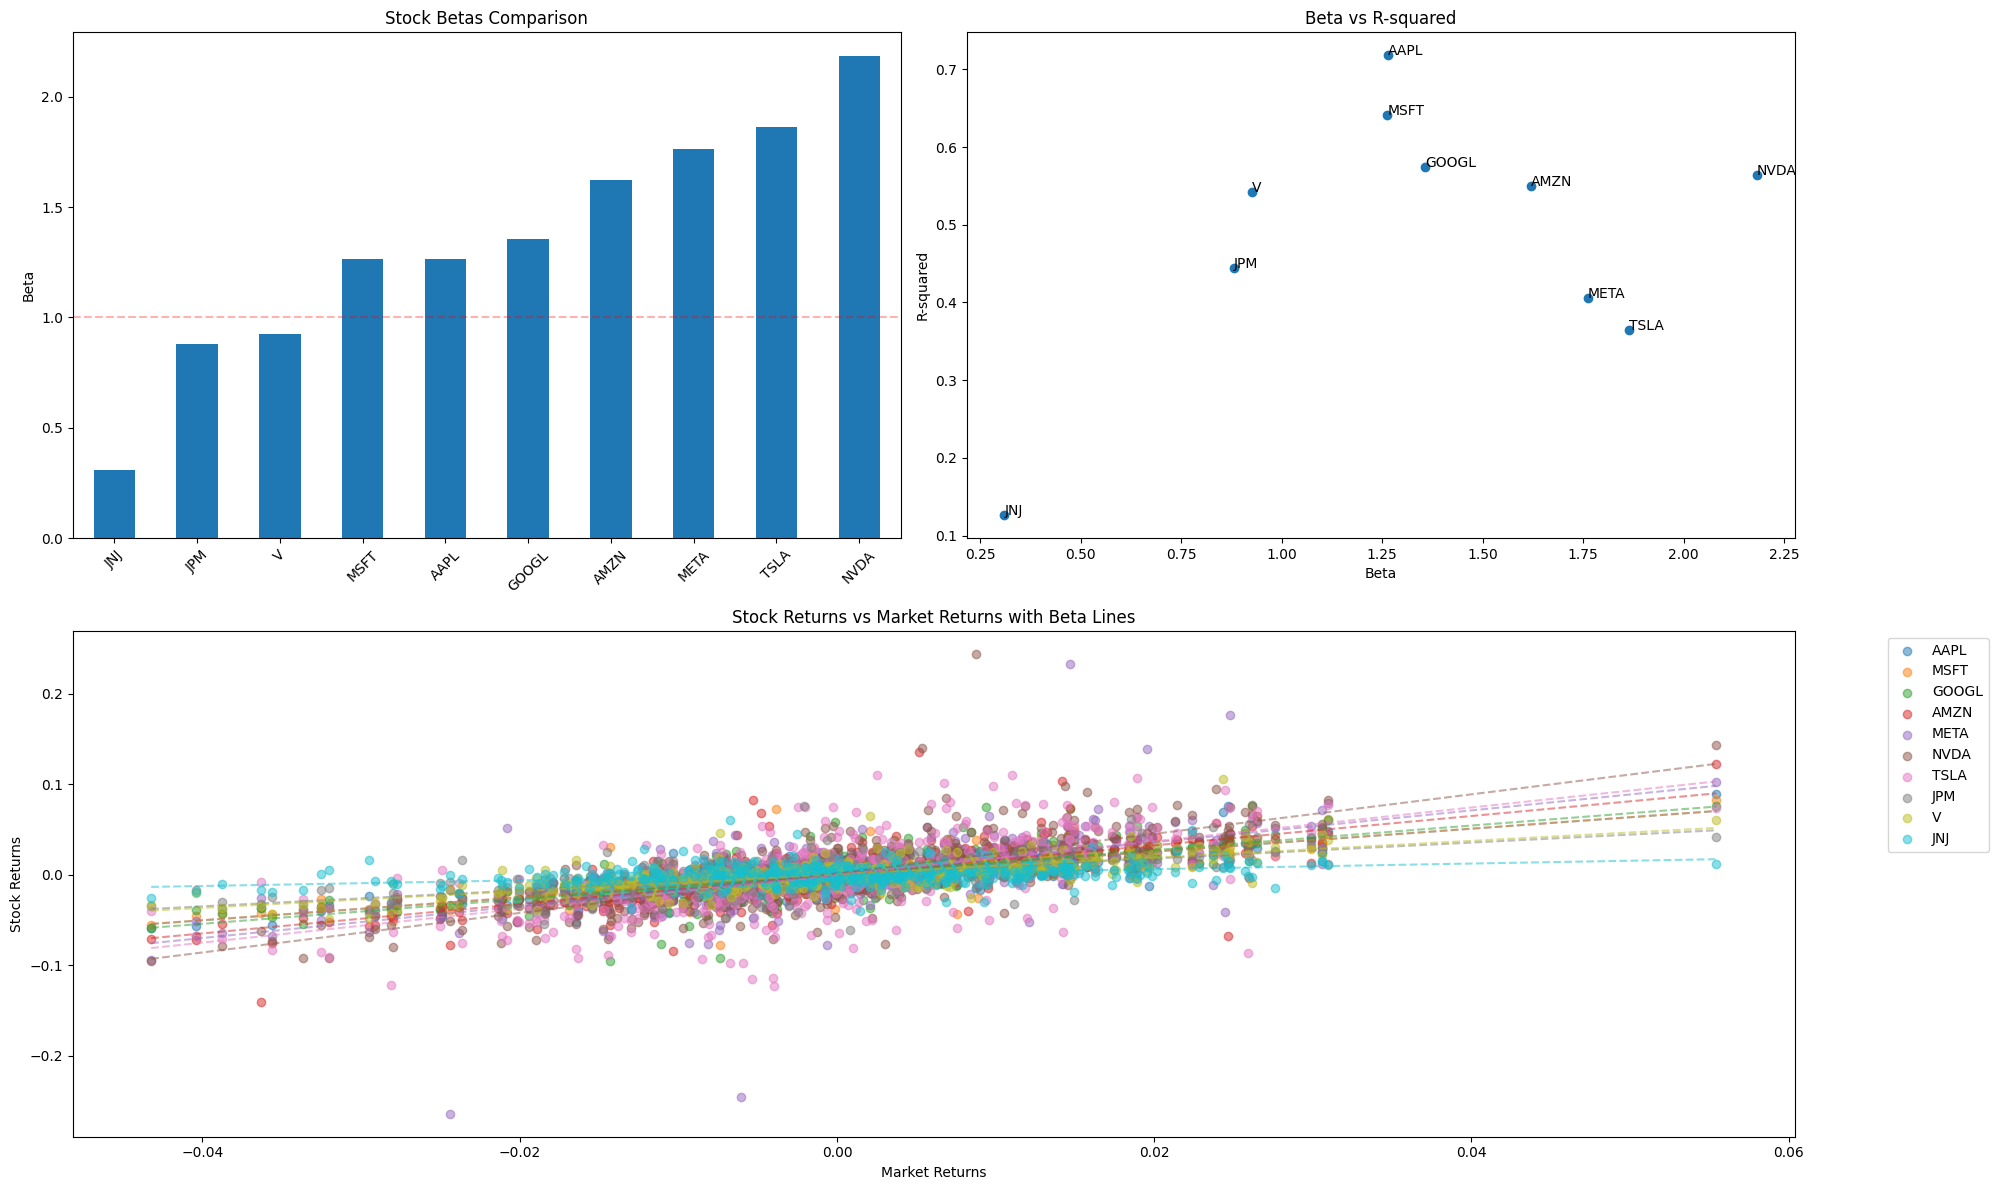

In [7]:
# Define parameters
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 
           'NVDA', 'TSLA', 'JPM', 'V', 'JNJ']
start_date = '2022-01-01'
end_date = '2024-01-01'
risk_free_rate = 0.045  # Current 10-year Treasury yield

# Create analyzer instance
analyzer = PortfolioAnalyzer(tickers, start_date, end_date)

# Download data
analyzer.download_data()

# Calculate individual betas
betas = analyzer.calculate_individual_betas()
print("\nIndividual Stock Betas:")
print(betas)

# Calculate portfolio beta (equal weights)
portfolio_beta = analyzer.calculate_portfolio_beta()
print(f"\nPortfolio Beta (equal weights): {portfolio_beta:.3f}")

# Calculate CAPM expected returns
expected_returns = analyzer.calculate_capm_returns(risk_free_rate)
print("\nExpected Returns (CAPM):")
print(expected_returns)

# Create visualization
analyzer.plot_beta_analysis()
plt.show()
